### Titanic classifier
The aim of this project is to detect who survived and who died in the Titanic. 
Firstly, we will browse through the data. Secondly, we will clean data.
Finally, we will try some models and analyse the outcome.

In [ ]:
from common_functions import *
import pandas as pd
PATH = "datasets/Titanic"

titanic_train = load_housing_data(PATH, "train.csv")
titanic_test = load_housing_data(PATH, "test.csv")

In [2]:
titanic_train.info()
titanic_train.describe()
# titanic_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
X_train = titanic_train



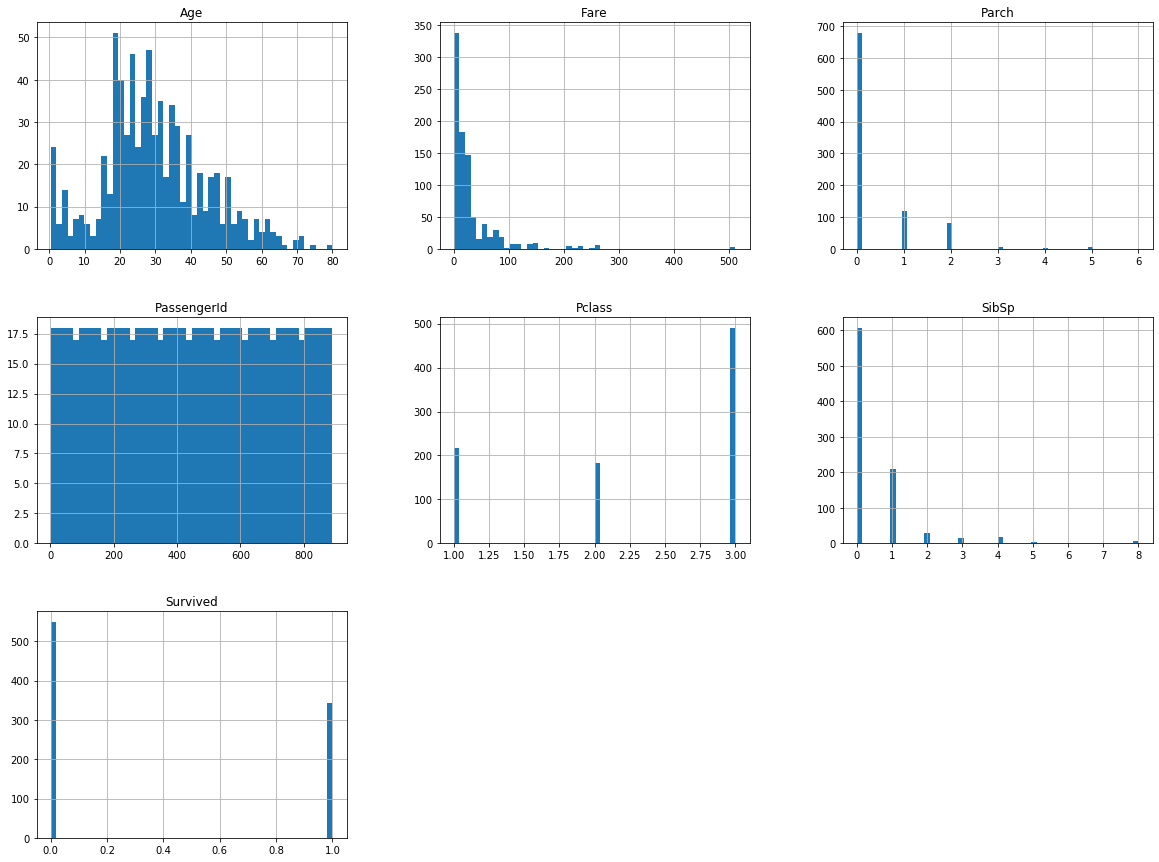

In [4]:
%matplotlib inline   
import matplotlib.pyplot as plt
# plot a glance on dataset
titanic_train.hist(bins=50, figsize=(20,15))
plt.show()

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
# Drop titanic objects
class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, features_names):
        self._features_names = features_names

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.drop(self._features_names, axis=1)
        return X
    

In [6]:
# Data cleaning
from sklearn.pipeline import Pipeline
dropped_columns = ["Name", "PassengerId", "Ticket", "Cabin"]

# Pipeline
preprocessing_pipeline = Pipeline([
    ('preprocessing_dropping', FeatureDropper(dropped_columns)),
])
X_train = preprocessing_pipeline.fit_transform(X_train)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


After drop the columns of the name and the passengers id, we have to encod several columns.
### pClass
- 1 = 1st
- 2 = 2nd
- 3 = 3rd

### Port of embarkation
- C = Cherbourg
- Q = Queenstown
- S = Southampton

In [7]:
# Drop rows where "Embarked" is NaN
X_train = X_train.dropna(axis=0, subset=["Embarked"])
X_train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
titanic_cat = X_train["Embarked"]
titanic_cat_encoded = label_encoder.fit_transform(titanic_cat)
titanic_cat_encoded
label_encoder.classes_

# List port names
# port_names = ["C", "Q", "S"]
# port_df = pd.DataFrame(port_names, columns=['port_names'])

def columns_encoded(classes, array, X):
    i = 0
    for cls in classes:
        X[cls] = array[:, i]
        i+=1
    return X

In [9]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
titanic_cat_1hot = cat_encoder.fit_transform(titanic_cat_encoded.reshape(-1,1))
X_train["C"]= titanic_cat_1hot.toarray()[:, 0]
X_train["Q"]= titanic_cat_1hot.toarray()[:, 1]
X_train["S"]= titanic_cat_1hot.toarray()[:, 2]

X_train = X_train.drop("Embarked", axis=1)

X_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,0,3,male,22.0,1,0,7.2500,0.0,0.0,1.0
1,1,1,female,38.0,1,0,71.2833,1.0,0.0,0.0
2,1,3,female,26.0,0,0,7.9250,0.0,0.0,1.0
3,1,1,female,35.0,1,0,53.1000,0.0,0.0,1.0
4,0,3,male,35.0,0,0,8.0500,0.0,0.0,1.0


In [10]:
# Binarize the person's sex
from sklearn.preprocessing import LabelBinarizer
binarize_encoder = LabelBinarizer()
sex_cat_1hot = binarize_encoder.fit_transform(X_train["Sex"])
X_train["is_male"] = sex_cat_1hot
X_train = X_train.drop("Sex", axis=1)

X_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,C,Q,S,is_male
0,0,3,22.0,1,0,7.2500,0.0,0.0,1.0,1
1,1,1,38.0,1,0,71.2833,1.0,0.0,0.0,0
2,1,3,26.0,0,0,7.9250,0.0,0.0,1.0,0
3,1,1,35.0,1,0,53.1000,0.0,0.0,1.0,0
4,0,3,35.0,0,0,8.0500,0.0,0.0,1.0,1


In [11]:
# Imputer for the age
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = "median")
# X_train_num = X_train.drop("Age", axis=1)
imputer.fit(X_train)

# Imputer transforms to numpy array
X_train_np = imputer.transform(X_train)

# Put it back into Pandas df
X_train = pd.DataFrame(X_train_np, columns=X_train.columns)


In [12]:
# Correlation matrix
corr_matrix = X_train.corr()
corr_matrix["Survived"]


Survived    1.000000
Pclass     -0.335549
Age        -0.069822
SibSp      -0.034040
Parch       0.083151
Fare        0.255290
C           0.169966
Q           0.004536
S          -0.151777
is_male    -0.541585
Name: Survived, dtype: float64

In [13]:
# Split the labels and the features
X_train_prepared = X_train.drop("Survived", axis=1)
y_train_labels = X_train["Survived"]

Data prepared, do the classification
This aim is to know if the person survived or not

In [14]:
# SGD Classifier
from sklearn.linear_model import SGDClassifier

# y_label=1 means that the person survived 
y_train_survived = (y_train_labels == 1)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_prepared, y_train_survived)


SGDClassifier(random_state=42)

In [15]:
some_people = X_train_prepared.iloc[[4]]
sgd_clf.predict(some_people)


array([False])

Measuring Accuracy Using Cross-Validation

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train_prepared, y_train_survived, cv=5, scoring="accuracy")

array([0.74157303, 0.58426966, 0.73033708, 0.69662921, 0.8079096 ])

Confusion matrix

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Show the prediction for each rows
y_train_pred = cross_val_predict(sgd_clf, X_train_prepared, y_train_survived, cv=3)

confusion_matrix(y_train_survived, y_train_pred)

array([[495,  54],
       [201, 139]], dtype=int64)

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score
def display_scores(y_train, y_pred):
    print("Precision : ", precision_score(y_train, y_pred))
    print("Recall : ", recall_score(y_train, y_pred))
    print("f1 : ", f1_score(y_train, y_pred))
    

In [19]:
display_scores(y_train_survived, y_train_pred)

Precision :  0.7202072538860104
Recall :  0.4088235294117647
f1 :  0.5215759849906191


Precision / Recall tradeoff
We can see that the recall is too high -> decrease the threshold can improve the classifier

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train_prepared, y_train_survived, cv=3, method="decision_function")

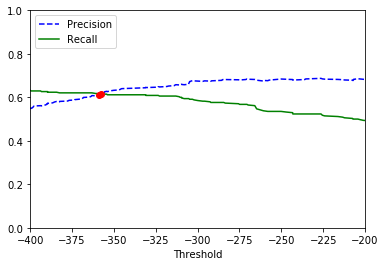

In [25]:
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_survived, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    # Zoom on the curves
    plt.xlim([-400, -200])
    # Intersection
    intersection = np.argwhere(np.diff(np.sign(precisions[:-1] - recalls[:-1]))).flatten()
    plt.plot(thresholds[intersection], precisions[:-1][intersection], 'ro')
    
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

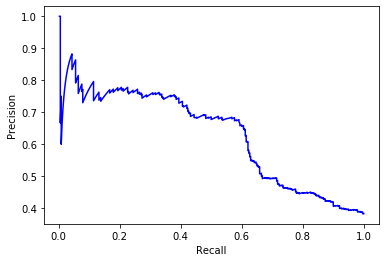

In [23]:
def plot_recall_vs_precision(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    
plot_recall_vs_precision(precisions, recalls)
plt.show()


In [33]:
# Threshold = -360
threshold = -360
# Create an array of probabilities
y_scores = sgd_clf.decision_function(X_train_prepared)

def adjusted_classes(y_scores, t):
    # This function adjusts class predictions based on the prediction threshold (t)
    return [True if y >= t else False for y in y_scores]

threshold_scores = adjusted_classes(y_scores, -360)


In [37]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_survived, threshold_scores)


array([[ 22, 527],
       [  2, 338]], dtype=int64)

In [38]:
display_scores(threshold_scores, y_train_labels)



Precision :  0.9941176470588236
Recall :  0.39075144508670523
f1 :  0.5609958506224066
